In [1]:
import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
%matplotlib inline

In [265]:
# # classification:  3 labels one hot, 5 features (gene)
# train_data = pickle.load( open( "../train_data_G3.p", "rb" ) )
# train_labels = pickle.load( open( "../train_labels_G3.p", "rb" ) )
# test_data = pickle.load( open( "../test_data_G3.p", "rb" ) )
# test_labels = pickle.load( open( "../test_labels_G3.p", "rb" ) )
# val_data = pickle.load( open( "../val_data_G3.p", "rb" ) )
# val_labels = pickle.load( open( "../val_labels_G3.p", "rb" ) )

In [266]:
# # classification:  21 labels one hot, 5 features (gene)
# train_data = pickle.load( open( "../train_data_G21.p", "rb" ) )
# train_labels = pickle.load( open( "../train_labels_G21.p", "rb" ) )
# test_data = pickle.load( open( "../test_data_G21.p", "rb" ) )
# test_labels = pickle.load( open( "../test_labels_G21.p", "rb" ) )
# val_data = pickle.load( open( "../val_data_G21.p", "rb" ) )
# val_labels = pickle.load( open( "../val_labels_G21.p", "rb" ) )

In [3]:
# classification:  3 labels one hot, 4 features (no gene)
train_data = pickle.load( open( "../train_data_N3.p", "rb" ) )
train_labels = pickle.load( open( "../train_labels_N3.p", "rb" ) )
test_data = pickle.load( open( "../test_data_N3.p", "rb" ) )
test_labels = pickle.load( open( "../test_labels_N3.p", "rb" ) )
val_data = pickle.load( open( "../val_data_N3.p", "rb" ) )
val_labels = pickle.load( open( "../val_labels_N3.p", "rb" ) )

In [45]:
# # classification:  21 labels one hot, 4 features (no gene)
# train_data = pickle.load( open( "../train_data_N21.p", "rb" ) )
# train_labels = pickle.load( open( "../train_labels_N21.p", "rb" ) )
# test_data = pickle.load( open( "../test_data_N21.p", "rb" ) )
# test_labels = pickle.load( open( "../test_labels_N21.p", "rb" ) )
# val_data = pickle.load( open( "../val_data_N21.p", "rb" ) )
# val_labels = pickle.load( open( "../val_labels_N21.p", "rb" ) )


In [269]:
# # get subset of 10 samples
# subset_train_data = train_data[0:1000]
# subset_train_labels = train_labels[0:1000]

In [4]:
G = "NG" # or "NG"
forget_b = 1
# weight_mean = 1
# bias_mean = 0.01
val_step = 100000

In [5]:
# Training Parameters
# learning_rate = 0.001 # optimize this
learning_rate = 0.001
training_steps = 1000000
batch_size = 1 # 128
display_step = 5000

In [6]:
# Network Parameters
num_input = 4
    # 28 # MNIST data input (img shape: 28*28)
timesteps = 23
    # 28 # timesteps
num_hidden = 64 # ?
    # 10 # hidden layer num of features
num_classes = 3 # figure out how to do regression
    # 10 # MNIST total classes (0-9 digits)

In [7]:
#this resets the graph - re-run tensor-flow specific things after it
tf.reset_default_graph() 

# tf Graph input
X = tf.placeholder("float", [None, timesteps, num_input])
Y = tf.placeholder("float", [None, num_classes])

# Define weights
weights = {
    # Hidden layer weights => 2*n_hidden because of forward + backward cells
    'out': tf.get_variable("my_int_variable", [2*num_hidden, num_classes],
  initializer=tf.glorot_uniform_initializer(seed = 23))
#     tf.Variable(tf.random_normal([2*num_hidden, num_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}




def BiRNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, num_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, num_input)
    x = tf.unstack(x, timesteps, 1)

    # Define lstm cells with tensorflow
    # Forward direction cell
    lstm_fw_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=forget_b)
    # Backward direction cell
    lstm_bw_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=forget_b)

    # Get lstm cell output
    try:
        outputs, _, _ = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                              dtype=tf.float32)
    except Exception: # Old TensorFlow version only returns outputs not states
        outputs = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                        dtype=tf.float32)

    # Linear activation, using rnn inner loop last output then sigmoid result to get output in range [0,1]

    # no sigmoid
#     print(len(outputs))
#     print(outputs[-1])
#     1/0
    return tf.matmul(outputs[-1], weights['out']) + biases['out']
    
    # sigmoid
#     return tf.nn.sigmoid(tf.matmul(outputs[-1], weights['out']) + biases['out'])




prediction = BiRNN(X, weights, biases)


# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=Y))
# loss_op = tf.reduce_mean(tf.losses.mean_squared_error(labels=Y, predictions=prediction))

# try reduce mean sq without using built in mse fn
# loss_op = tf.reduce_mean(tf.square(Y - prediction))


# optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)  # switch to adam optimizer
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
# prediction = tf.nn.softmax(prediction)
prediction = tf.argmax(tf.nn.softmax(prediction), 1)


# correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
correct_pred = tf.equal(prediction, tf.argmax(Y, 1))

accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# accuracy = tf.reduce_mean(tf.losses.mean_squared_error(Y, prediction))
# accuracy = tf.reduce_mean(abs(Y-prediction))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [8]:
def get_batch(batch_size, x, y):
    i = np.random.randint(0,x.shape[0], size=(batch_size))
    return np.array(x[i]), np.array(y[i])

In [ ]:
# train_data = subset_train_data
# train_labels = subset_train_labels
# val_data = subset_train_data
# val_labels = subset_train_labels


# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)
    
    # things to save during display step + val step
    train_losses = []
    val_losses = []
    
    
    for step in range(1, training_steps+1):
        batch_x, batch_y = get_batch(batch_size, train_data, train_labels)
        # Reshape data to get 28 seq of 28 elements
        
        
        # with regression maybe uncomment this??
#         batch_x = batch_x.reshape((batch_size, timesteps, num_input))
#         batch_y = batch_y.reshape((batch_size, num_classes))
        
    
        # Run optimization op (backprop) in every training step
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        
        
        # in display step, clac train_losses
        if step % display_step == 0 or step == 1:
            t_loss = sess.run(loss_op, feed_dict={X: batch_x, Y: batch_y})
            train_losses.append(t_loss)
        
        # in val step, calc val_losses
        if step % val_step == 0 or step == 1:
            vl_temp = []
            for i in range(val_labels.shape[0]/batch_size):
#                 val_labels = val_labels.reshape((val_labels.shape[0], num_classes)) # < don't need this??

                x = val_data[i*batch_size: i*batch_size + batch_size].reshape((batch_size,timesteps, num_input))
                y = val_labels[i*batch_size:i*batch_size + batch_size].reshape((batch_size,num_classes))

                vl_temp.append(sess.run(loss_op, feed_dict={X: x, Y:y}))
            v_loss = np.mean(vl_temp)
            val_losses.append(v_loss)

            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(t_loss) + ", Validation Loss= " + \
                     "{:.3f}".format(v_loss))
        
    print("Optimization Finished!")

    #######################################################################################################
    # Calculate accuracy and predictions for validation set
    val_preds = []
    val_accs_final = []
    val_losses_final = []

    for i in range(val_labels.shape[0]/batch_size):
#         val_labels = val_labels.reshape((val_labels.shape[0], num_classes)) # < don't need this??
        x = val_data[i*batch_size: i*batch_size + batch_size].reshape((batch_size,timesteps, num_input))
        y = val_labels[i*batch_size:i*batch_size + batch_size].reshape((batch_size,num_classes))
        val_preds.append(sess.run(prediction, feed_dict={X: x}))      
        val_accs_final.append(sess.run(accuracy, feed_dict={X: x, Y:y}))
        val_losses_final.append(sess.run(loss_op, feed_dict={X: x, Y:y}))
    
    val_acc_f = np.mean(val_accs_final)
    val_loss_f = np.mean(val_losses_final)
    
    print("Final Validtion Accuracy = " + "{:.4f}".format(val_acc_f))
    print("Final Validation Loss = " + "{:.4f}".format(val_loss_f))
    
    
    
    
    #######################################################################################################
    # Calculate accuracy and predictions for testing set
    test_preds = []
    test_accs_final = []
    test_losses_final = []

    for i in range(test_labels.shape[0]/batch_size):
#         val_labels = val_labels.reshape((val_labels.shape[0], num_classes)) # < don't need this??
        x = test_data[i*batch_size: i*batch_size + batch_size].reshape((batch_size,timesteps, num_input))
        y = test_labels[i*batch_size:i*batch_size + batch_size].reshape((batch_size,num_classes))
        test_preds.append(sess.run(prediction, feed_dict={X: x}))      
        test_accs_final.append(sess.run(accuracy, feed_dict={X: x, Y:y}))
        test_losses_final.append(sess.run(loss_op, feed_dict={X: x, Y:y}))
    
    test_acc_f = np.mean(test_accs_final)
    test_loss_f = np.mean(test_losses_final)
    
    print("Final Test Accuracy = " + "{:.4f}".format(test_acc_f))
    print("Final Test Loss = " + "{:.4f}".format(test_loss_f))
    
    #######################################################################################################
    # Calculate accuracy and predictions for doench data
#     d_preds = []
#     d_accs_final = []
#     d_losses_final = []

#     for i in range(d_labels.shape[0]/batch_size):
# #         val_labels = val_labels.reshape((val_labels.shape[0], num_classes)) # < don't need this??
#         x = d_data[i*batch_size: i*batch_size + batch_size].reshape((batch_size,timesteps, num_input))
#         y = d_labels[i*batch_size:i*batch_size + batch_size].reshape((batch_size,num_classes))
#         d_preds.append(sess.run(prediction, feed_dict={X: x}))      
#         d_accs_final.append(sess.run(accuracy, feed_dict={X: x, Y:y}))
#         d_losses_final.append(sess.run(loss_op, feed_dict={X: x, Y:y}))
    
#     d_acc_f = np.mean(d_accs_final)
#     d_loss_f = np.mean(d_losses_final)
    
#     print("Final Doench Accuracy = " + "{:.4f}".format(d_acc_f))
#     print("Final Doench Loss = " + "{:.4f}".format(d_loss_f))
    

Step 1, Minibatch Loss= 0.7431, Validation Loss= 1.067
Step 100000, Minibatch Loss= 1.0651, Validation Loss= 0.936
Step 200000, Minibatch Loss= 0.4111, Validation Loss= 0.910
Step 300000, Minibatch Loss= 0.4516, Validation Loss= 0.910
Step 400000, Minibatch Loss= 0.8561, Validation Loss= 0.915
Step 500000, Minibatch Loss= 0.4646, Validation Loss= 0.926
Step 600000, Minibatch Loss= 0.5012, Validation Loss= 0.925


In [43]:
# preds = [v[0] for v in val_preds]
# # val_labels = np.argmax(val_labels, axis=1)
# plt.scatter(preds, val_labels, alpha=0.01)

# z = np.polyfit(np.array(preds).reshape(len(preds),), val_labels.reshape(val_labels.shape[0],),1)
# p = np.poly1d(z)
# plt.plot(preds, p(preds), "r")

# plt.xlabel("predicted effect")
# plt.ylabel("actual effect")

# plt.show()

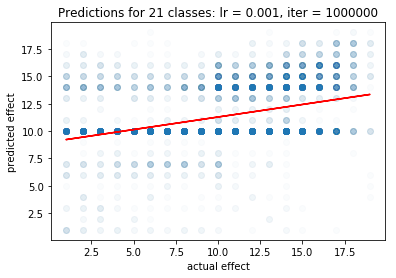

In [41]:
# final plot
preds = [v[0] for v in val_preds]
# val_labels = np.argmax(val_labels, axis=1)
plt.scatter(val_labels, preds, alpha=0.02)

z = np.polyfit(val_labels.reshape(val_labels.shape[0],),np.array(preds).reshape(len(preds),),1)
p = np.poly1d(z)
plt.plot(val_labels, p(val_labels), "r")

plt.ylabel("predicted effect")
plt.xlabel("actual effect")
plt.title("Predictions for 21 classes: lr = 0.001, iter = 1000000")

plt.show()

In [27]:
import scipy.stats as st
st.spearmanr(preds, val_labels)


SpearmanrResult(correlation=0.38176004816057907, pvalue=1.7243385873084822e-246)

In [48]:
# test on testing set
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)
    
    # Calculate accuracy and predictions for validation set
    test_preds = []
    test_accs_final = []
    test_losses_final = []

    for i in range(test_labels.shape[0]/batch_size):
#         val_labels = val_labels.reshape((val_labels.shape[0], num_classes)) # < don't need this??
        x = test_data[i*batch_size: i*batch_size + batch_size].reshape((batch_size,timesteps, num_input))
        y = test_labels[i*batch_size:i*batch_size + batch_size].reshape((batch_size,num_classes))
        test_preds.append(sess.run(prediction, feed_dict={X: x}))      
        test_accs_final.append(sess.run(accuracy, feed_dict={X: x, Y:y}))
        test_losses_final.append(sess.run(loss_op, feed_dict={X: x, Y:y}))
    
    test_acc_f = np.mean(test_accs_final)
    test_loss_f = np.mean(test_losses_final)
    
    print("Final Test Accuracy = " + "{:.4f}".format(test_acc_f))
    print("Final Test Loss = " + "{:.4f}".format(test_loss_f))

Final Test Accuracy = 0.0493
Final Test Loss = 3.5171


In [53]:
np.mean(val_preds)

13.0

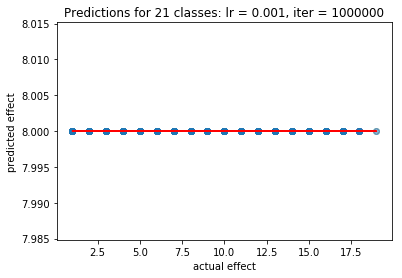

In [49]:
# final plot for TESTING data
t_preds = [v[0] for v in test_preds]
test_labels = np.argmax(test_labels, axis=1)
plt.scatter(test_labels, t_preds, alpha=0.02)

z = np.polyfit(test_labels.reshape(test_labels.shape[0],),np.array(t_preds).reshape(len(t_preds),),1)
p = np.poly1d(z)
plt.plot(test_labels, p(test_labels), "r")

plt.ylabel("predicted effect")
plt.xlabel("actual effect")
plt.title("Predictions for 21 classes: lr = 0.001, iter = 1000000")

plt.show()

In [ ]:
# read doench pickle file
doech_data

In [ ]:
# test on doench set
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)
    
    # Calculate accuracy and predictions for validation set
    test_preds = []
    test_accs_final = []
    test_losses_final = []

    for i in range(test_labels.shape[0]/batch_size):
#         val_labels = val_labels.reshape((val_labels.shape[0], num_classes)) # < don't need this??
        x = test_data[i*batch_size: i*batch_size + batch_size].reshape((batch_size,timesteps, num_input))
        y = test_labels[i*batch_size:i*batch_size + batch_size].reshape((batch_size,num_classes))
        test_preds.append(sess.run(prediction, feed_dict={X: x}))      
        test_accs_final.append(sess.run(accuracy, feed_dict={X: x, Y:y}))
        test_losses_final.append(sess.run(loss_op, feed_dict={X: x, Y:y}))
    
    test_acc_f = np.mean(test_accs_final)
    test_loss_f = np.mean(test_losses_final)

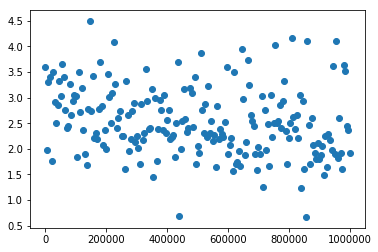

In [42]:
plt.scatter(np.arange(0, training_steps+display_step, display_step), train_losses)

In [110]:
fn = '../pred2_NG_3_32_0.001_1_default_default_0.5777142_0.90283686_0.59467787.csv'
pred_labels = np.genfromtxt(fn, delimiter=",")

In [112]:
pred_labels

array([[1., 1.],
       [1., 0.],
       [1., 1.],
       ...,
       [1., 1.],
       [1., 2.],
       [1., 1.]])

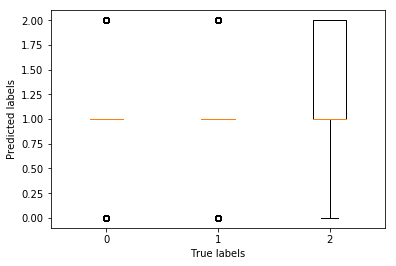

In [114]:
num_classes = 3
boxplot_data = []
preds_np = np.array(preds)
possible_labels = range(num_classes)
for l in possible_labels:
    boxplot_data.append(pred_labels[np.where(pred_labels[:,1] == l)][:,0])
plt.figure()
plt.boxplot(boxplot_data)
plt.xticks(range(1,num_classes+1),range(num_classes))
plt.ylabel("Predicted labels")
plt.xlabel("True labels")
plt.show()

In [227]:
# things to calculate:
# at each time step: train_losses, val_losses
# at the end: train_acc, val_acc(done), preds(done), val_labels(done)

In [30]:
weight_mean="default"
bias_mean="default"

In [31]:
####### saving results summary for each run

In [32]:
# 1. overall_results
# columns = gene(G/NG) , num_classes(1,3,21), num_hidden(8,32,128), lr(0.1,0.01,0.001,0.0001), 
    # forget(0,0.5,1), weight(0,1,2), bias(0.01,0.001), train_loss, val_loss, train_acc, val_acc

# output_file = open("../overall_results.csv", "a")
output_file = open("../overall_results2.csv", "a")

# output_file = open("../val_same_as_train_results_1000.csv", "a")
output_lst = [G, num_classes, num_hidden, learning_rate, forget_b, weight_mean, bias_mean, train_losses[-1], val_losses[-1], val_acc_f]
output_file.writelines(",".join([str(i) for i in output_lst])+"\n")
output_file.close()


In [33]:
# 2. prediction and true labels
# p_fname = "../pred_" + "_".join([str(i) for i in output_lst]) + ".csv"
p_fname = "../pred2_" + "_".join([str(i) for i in output_lst]) + ".csv"
# p_fname = "../same_valtrain1000_pred_" + "_".join([str(i) for i in output_lst]) + ".csv"
pred_labels = np.vstack((np.array(preds), val_labels)).T
np.savetxt(p_fname, pred_labels, delimiter=",")

In [34]:
# 3. training loss over time
# tl_fname = "../train_loss_" + "_".join([str(i) for i in output_lst]) + ".csv"
tl_fname = "../train_loss2_" + "_".join([str(i) for i in output_lst]) + ".csv"
# tl_fname = "../same_valtrain1000_train_loss_" + "_".join([str(i) for i in output_lst]) + ".csv"
train_loss_time = np.vstack((np.arange(0, training_steps+display_step, display_step), train_losses)).T
np.savetxt(tl_fname, train_loss_time, delimiter=",")

In [35]:
# 4. validation loss over time
# vl_fname = "../val_loss_" + "_".join([str(i) for i in output_lst]) + ".csv"
vl_fname = "../val_loss2_" + "_".join([str(i) for i in output_lst]) + ".csv"
# vl_fname = "../same_valtrain1000_val_loss_" + "_".join([str(i) for i in output_lst]) + ".csv"
val_loss_time = np.vstack((np.arange(0, training_steps+val_step, val_step), val_losses)).T
np.savetxt(vl_fname, val_loss_time, delimiter=",")

In [82]:
# train_data = subset_train_data
# train_labels = subset_train_labels
# val_data = subset_train_data
# val_labels = subset_train_labels


# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)
    
    # things to save during display step + val step
    train_losses = []
    val_losses = []
    
    
    for step in range(1, training_steps+1):
        batch_x, batch_y = get_batch(batch_size, train_data, train_labels)
        # Reshape data to get 28 seq of 28 elements
        
        
        # with regression maybe uncomment this??
#         batch_x = batch_x.reshape((batch_size, timesteps, num_input))
#         batch_y = batch_y.reshape((batch_size, num_classes))
        
    
        # Run optimization op (backprop) in every training step
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        
        
        # in display step, clac train_losses
        if step % display_step == 0 or step == 1:
            t_loss = sess.run(loss_op, feed_dict={X: batch_x, Y: batch_y})
            train_losses.append(t_loss)
        
        # in val step, calc val_losses
        if step % val_step == 0 or step == 1:
            vl_temp = []
            for i in range(val_labels.shape[0]/batch_size):
#                 val_labels = val_labels.reshape((val_labels.shape[0], num_classes)) # < don't need this??

                x = val_data[i*batch_size: i*batch_size + batch_size].reshape((batch_size,timesteps, num_input))
                y = val_labels[i*batch_size:i*batch_size + batch_size].reshape((batch_size,num_classes))

                vl_temp.append(sess.run(loss_op, feed_dict={X: x, Y:y}))
            v_loss = np.mean(vl_temp)
            val_losses.append(v_loss)

            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(t_loss) + ", Validation Loss= " + \
                     "{:.3f}".format(v_loss))
        
    print("Optimization Finished!")

    # Calculate accuracy and predictions for validation set
    val_preds = []
    val_accs_final = []
    val_losses_final = []

    for i in range(val_labels.shape[0]/batch_size):
#         val_labels = val_labels.reshape((val_labels.shape[0], num_classes)) # < don't need this??
        x = val_data[i*batch_size: i*batch_size + batch_size].reshape((batch_size,timesteps, num_input))
        y = val_labels[i*batch_size:i*batch_size + batch_size].reshape((batch_size,num_classes))
        val_preds.append(sess.run(prediction, feed_dict={X: x}))      
        val_accs_final.append(sess.run(accuracy, feed_dict={X: x, Y:y}))
        val_losses_final.append(sess.run(loss_op, feed_dict={X: x, Y:y}))
    
    val_acc_f = np.mean(val_accs_final)
    val_loss_f = np.mean(val_losses_final)
    
    print("Final Validtion Accuracy = " + "{:.4f}".format(val_acc_f))
    print("Final Validation Loss = " + "{:.4f}".format(val_loss_f))

Step 1, Minibatch Loss= 5.3221, Validation Loss= 3.404
Step 100000, Minibatch Loss= 2.5836, Validation Loss= 2.730
Optimization Finished!
Final Validtion Accuracy = 0.1514
Final Validation Loss = 2.7296


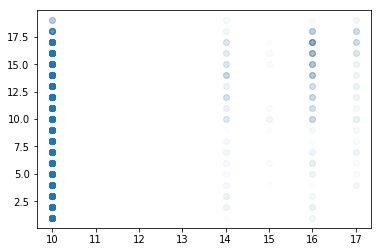

In [83]:
preds = [v[0] for v in val_preds]
val_labels = np.argmax(val_labels, axis=1)
plt.scatter(preds, val_labels, alpha=0.01)
plt.show()

In [84]:
pred_labels = np.vstack((np.array(preds), val_labels)).T

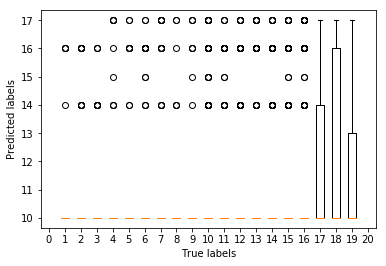

In [104]:
boxplot_data = []
preds_np = np.array(preds)
possible_labeuls = range(num_classes)
for l in possible_labels:
    boxplot_data.append(pred_labels[np.where(pred_labels[:,1] == l)][:,0])
plt.figure()
plt.boxplot(boxplot_data)
plt.xticks(range(1,num_classes+1),range(num_classes))
plt.ylabel("Predicted labels")
plt.xlabel("True labels")
plt.show()